<a href="https://colab.research.google.com/github/MatheusSC017/PassMarkWebScraping/blob/main/PassMarkWebScrapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PassMark Web Scraping

## Libraries

In [ ]:
import bs4
import requests
import re
import pandas as pd
import numpy as np
from copy import deepcopy
from openpyxl import Workbook

## Scraping a video card page table

The page that we will scrape will be [Video Card Benchmark](https://www.videocardbenchmark.net/gpu_list.php), this page was chosen because the structure of the page and the data it contains are interesting for analysis and research.

<center>

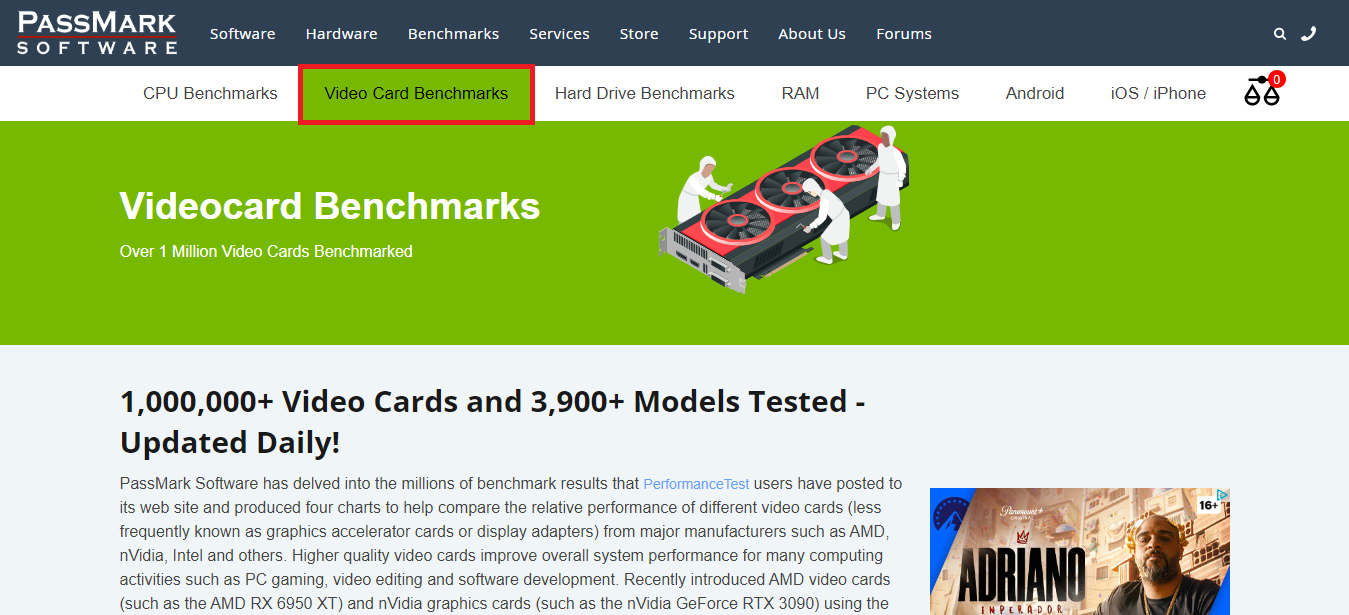

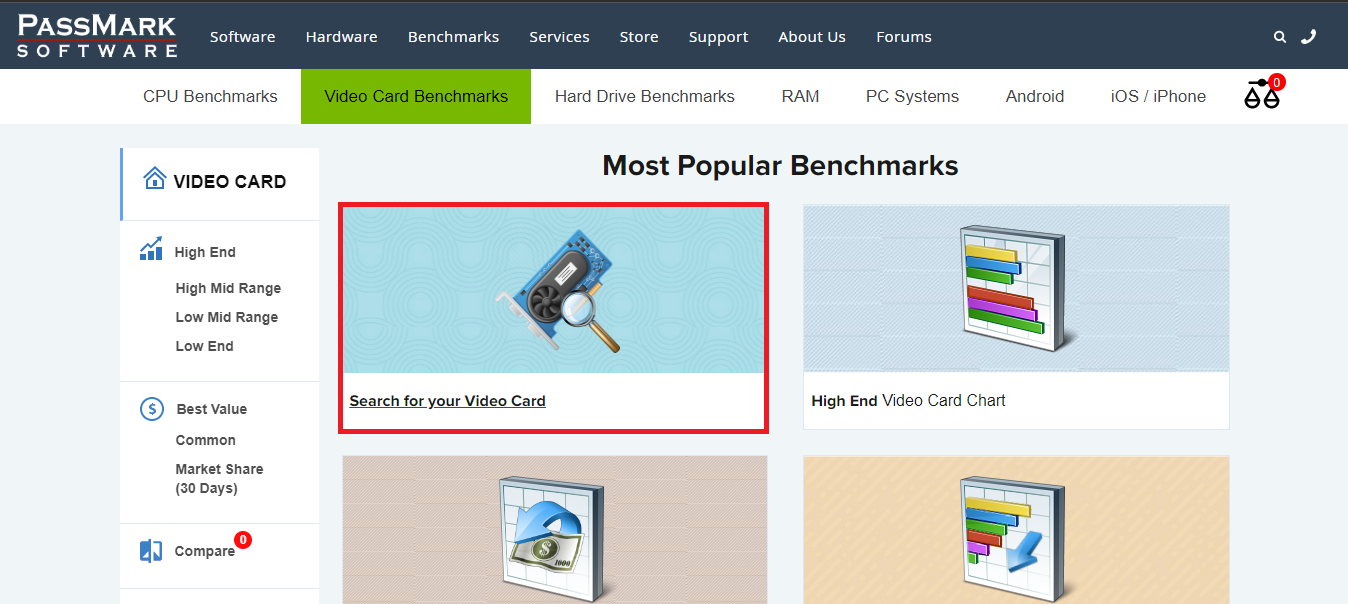

</center>


### Getting the data


the first code block will be responsible for scraping the page table:

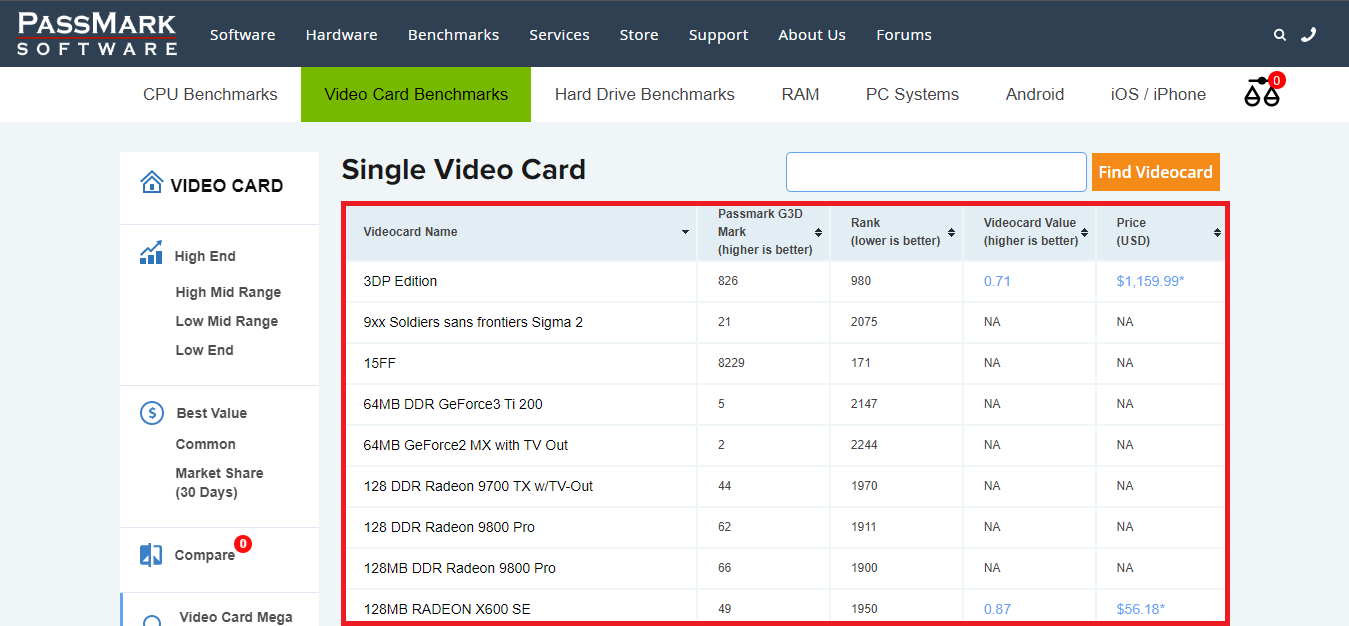

In [ ]:
url = 'https://www.videocardbenchmark.net/gpu_list.php'

response = requests.get(url)

html = bs4.BeautifulSoup(response.text, 'html.parser')

table = html.find(id='cputable')



Then we will split the table data into two subsets, the first will contain information about the data we are scraping, the second subset will contain the table data

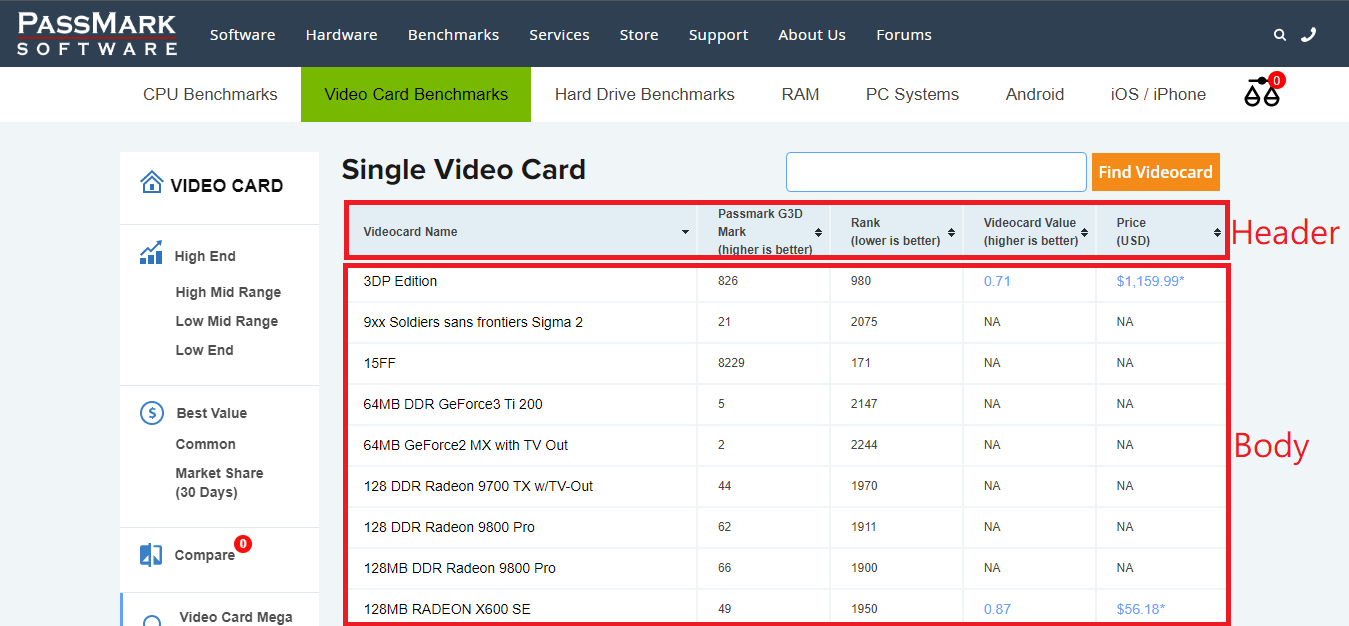



In [ ]:
head = table.find('thead')
body = table.find('tbody').find_all('tr')

### Table data scraping

Now, let's create a function that will read the table rows and separate the information from it.

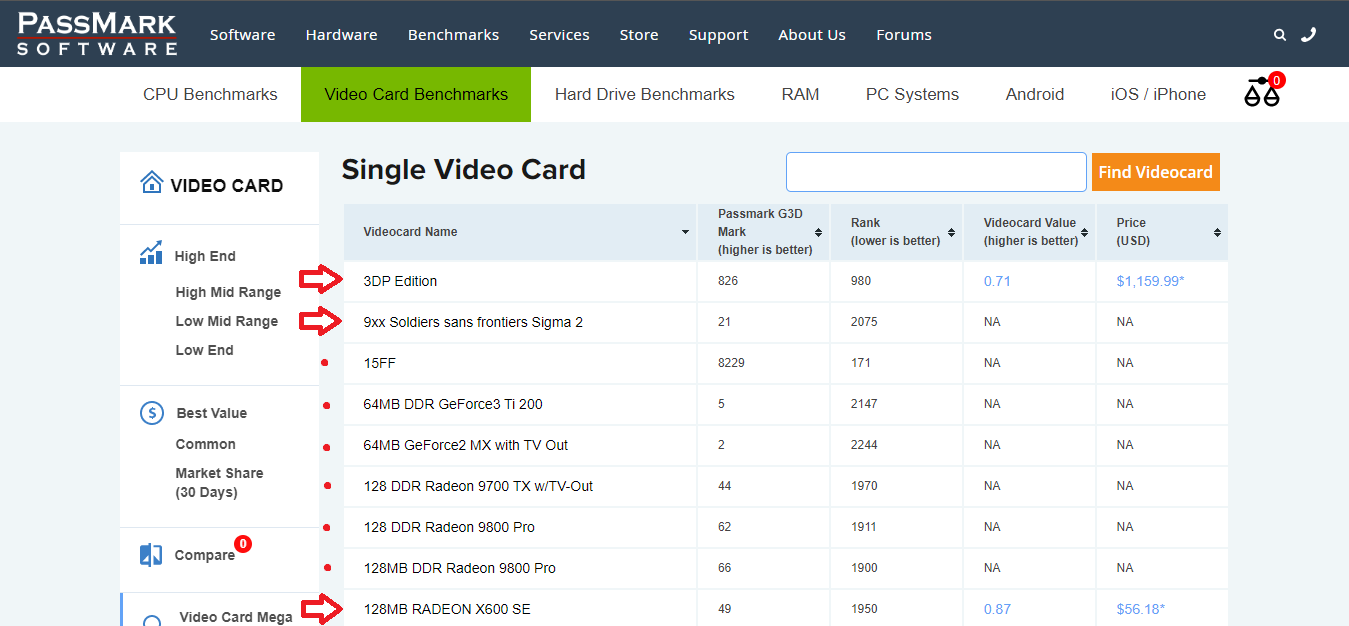


In [ ]:
def read_table_data(table):
    table_data = list()
    for line in table:
        line_data = line.find_all('td')
        table_data.append([data.text for data in line_data])
    return table_data

In [ ]:
video_cards_data = read_table_data(body)
video_cards_data[:5]

[['128 DDR Radeon 9700 TX w/TV-Out', '44', '1970', 'NA', 'NA'],
 ['128 DDR Radeon 9800 Pro', '62', '1911', 'NA', 'NA'],
 ['128MB DDR Radeon 9800 Pro', '66', '1900', 'NA', 'NA'],
 ['128MB RADEON X600 SE', '49', '1950', '0.87', '$56.18*'],
 ['15FF', '8229', '170', 'NA', 'NA']]

### Data typing and initial cleanup

In this section, we will clean the data, through the application of a method that performs the cleaning process and the conversion of values.

*   Convert to float:

'U\$ 1,200.00\*' => 'U$ 1200.00*' => '1200.00' => 1200.00

*   Convert to int:

In [ ]:
def convert_float(value):
    try:
        value = re.sub(',', '', value)
        new_value = re.findall('[0-9]+\.?[0-9]{0,2}', value)
        if not len(new_value):
            return np.NaN
        return float(new_value[0])
    except TypeError:
        return np.NaN

In [ ]:
def convert_int(value):
    try:
        value = re.findall('-?[0-9]+', value)
        if not len(value):
            return np.NaN
        return int(value[0])
    except TypeError:
        return np.NaN

In [ ]:
# Applying cleaning methods
for line in video_cards_data:
    line[1] = convert_int(line[1])
    line[2] = convert_int(line[2])
    line[3] = convert_float(line[3])
    line[4] = convert_float(line[4])

### Reading the table header

Next, let's split the table header to extract the title of each column.

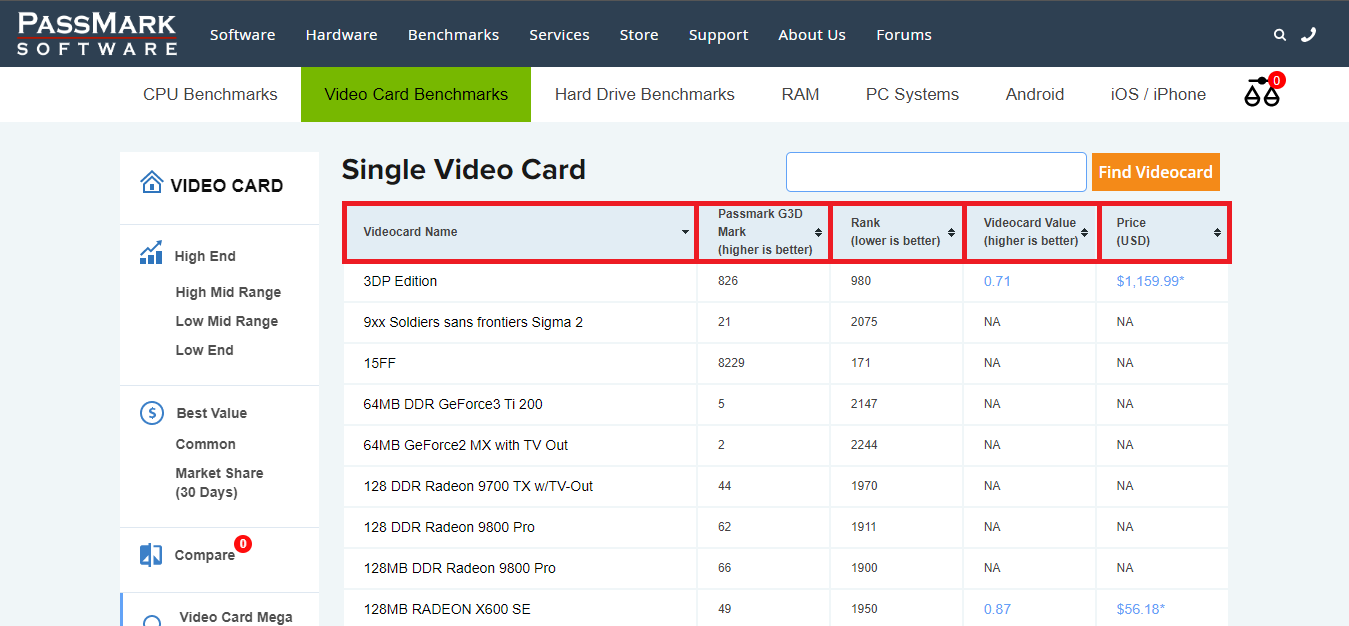



In [ ]:
def read_table_head(head):
    columns = [column.text for column in head.find_all('th')]
    return columns

In [ ]:
columns = read_table_head(head)
columns

['Videocard Name',
 'Passmark G3D Mark\n(higher is better)',
 'Rank\n(lower is better)',
 'Videocard Value\n(higher is better)',
 'Price\n(USD)']

### DataFrame creation
Next, we'll convert the data into a DataFrame for easier visualization and analysis.

In [ ]:
video_cards_df = pd.DataFrame(data=video_cards_data, columns=columns)
video_cards_df

,Videocard Name,Passmark G3D Mark\n(higher is better),Rank\n(lower is better),Videocard Value\n(higher is better),Price\n(USD)
0,128 DDR Radeon 9700 TX w/TV-Out,44,1970,NaN,NaN
1,128 DDR Radeon 9800 Pro,62,1911,NaN,NaN
2,128MB DDR Radeon 9800 Pro,66,1900,NaN,NaN
3,128MB RADEON X600 SE,49,1950,0.87,56.18
4,15FF,8229,170,NaN,NaN
...,...,...,...,...,...
2303,Xabre,5,2160,NaN,NaN
2304,XFX Radeon HD 4650 AGP,109,1758,NaN,NaN
2305,XGI Volari Family v1.13.23.D_V,4,2179,NaN,NaN
2306,ZX Chrome 645/640 GPU,147,1652,NaN,NaN


### Data analysis
Through pandas' info() method, we find out the large number of samples with missing data, as well as being able to analyze the distribution of the data and other information.

In [ ]:
video_cards_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2308 entries, 0 to 2307
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Videocard Name                        2308 non-null   object 
 1   Passmark G3D Mark
(higher is better)  2308 non-null   int64  
 2   Rank
(lower is better)                2308 non-null   int64  
 3   Videocard Value
(higher is better)    558 non-null    float64
 4   Price
(USD)                           558 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 90.3+ KB


In [ ]:
video_cards_df.describe()

,Passmark G3D Mark\n(higher is better),Rank\n(lower is better),Videocard Value\n(higher is better),Price\n(USD)
count,2308.000000,2308.000000,558.000000,558.000000
mean,2111.667678,1113.837522,11.371882,432.300358
std,3920.029916,665.834805,13.443697,751.548862
min,1.000000,-1.000000,0.000000,17.500000
25%,129.000000,536.750000,1.715000,109.990000
50%,660.000000,1113.500000,6.715000,210.955000
75%,1958.250000,1690.250000,16.890000,434.180000
max,29993.000000,2267.000000,143.920000,8999.000000


### Data cleaning
Now we will apply the pandas library method to discard the missing values and check if the dataset has duplicate columns

*   Dropping samples with missing values



In [ ]:
video_cards_df = video_cards_df.dropna()
video_cards_df

,Videocard Name,Passmark G3D Mark\n(higher is better),Rank\n(lower is better),Videocard Value\n(higher is better),Price\n(USD)
3,128MB RADEON X600 SE,49,1950,0.87,56.18
6,256MB RADEON X600,67,1894,0.42,160.49
7,3DP Edition,826,980,0.71,1159.99
33,Barco MXRT 2600,900,921,4.52,199.00
34,Barco MXRT 5400,1161,773,5.72,203.00
...,...,...,...,...,...
2269,Tesla M6,7509,191,37.73,199.00
2270,Tesla M60,7770,184,9.86,787.90
2274,Tesla T4,10807,114,2.36,4581.01
2275,TITAN RTX,20051,18,7.17,2794.99


*   Checking duplicated values

There isn't duplicated values

In [ ]:
sum(video_cards_df.duplicated('Videocard Name'))

0

## Class to scrape page tables

In [ ]:
class PassMarkPCComponentsAndAndroid:
    def __init__(self, url):
        self._url = url
        self._title_page = None
        self._feature_names = None
        self._raw_data = None
        self._cleaned_data = None

        self.scrape()

    def scrape(self):
        response = requests.get(self._url)
        html = bs4.BeautifulSoup(response.text, 'html.parser')
        
        table = html.find(id='cputable')
        head = table.find('thead')
        body = table.find('tbody').find_all('tr')
        
        self._title_page = html.find(class_='main-title').find('h2').text
        self._feature_names = self._get_table_head(head)
        self._raw_data = self._get_table_content(body)

    def _get_table_head(self, head):
        columns = [column.text for column in head.find_all('th')]
        return columns

    def _get_table_content(self, table):
        table_data = list()
        for line in table:
            line_data = line.find_all('td')
            table_data.append([data.text for data in line_data])
        return table_data

    @staticmethod
    def convert_float(value):
        try:
            value = re.sub(',', '', value)
            new_value = re.findall('[0-9]+\.?[0-9]{0,2}', value)
            if not len(new_value):
                return np.NaN
            return float(new_value[0])
        except TypeError:
            return np.NaN

    @staticmethod
    def convert_int(value):
        try:
            value = re.findall('-?[0-9]+', value)
            if not len(value):
                return np.NaN
            return int(value[0])
        except TypeError:
            return np.NaN

    def _clean(self, table_data):
        for line in table_data:
            line[1] = self.convert_int(line[1])
            line[2] = self.convert_int(line[2])
            line[3] = self.convert_float(line[3])
            line[4] = self.convert_float(line[4])
        return table_data
    
    def get_feature_names(self):
        return self._feature_names

    def get_raw_data(self):
        return self._raw_data
    
    def get_cleaned_data(self):
        if self._cleaned_data:
            return self._cleaned_data
        else:
            self._cleaned_data = deepcopy(self._raw_data)
            return self._clean(self._cleaned_data)

    def get_raw_dataframe(self):
        return pd.DataFrame(self.get_raw_data(), 
                            columns=self.get_feature_names())
    
    def get_cleaned_dataframe(self):
        return pd.DataFrame(self.get_cleaned_data(), 
                            columns=self.get_feature_names())

    def save(self, file_name='PassMark'):
        wb = Workbook()
        file_dest = file_name + '.xlsx'

        ws = wb.active
        ws.title = self._title_page

        ws.append(self.get_feature_names())
        for data in self.get_cleaned_data():
            ws.append(data)

        wb.save(filename=file_dest)

In [ ]:
passmark = PassMarkPCComponentsAndAndroid('https://www.cpubenchmark.net/cpu_list.php')

In [ ]:
passmark.get_raw_data()[:5]

[['AArch64 rev 0 (aarch64)', '2,711', '1809', 'NA', 'NA'],
 ['AArch64 rev 1 (aarch64)', '2,469', '1907', 'NA', 'NA'],
 ['AArch64 rev 2 (aarch64)', '2,287', '2005', 'NA', 'NA'],
 ['AArch64 rev 4 (aarch64)', '1,787', '2288', 'NA', 'NA'],
 ['AC8257V/WAB', '740', '3133', 'NA', 'NA']]

In [ ]:
passmark.get_cleaned_data()[:5]

[['AArch64 rev 0 (aarch64)', 2, 1809, nan, nan],
 ['AArch64 rev 1 (aarch64)', 2, 1907, nan, nan],
 ['AArch64 rev 2 (aarch64)', 2, 2005, nan, nan],
 ['AArch64 rev 4 (aarch64)', 1, 2288, nan, nan],
 ['AC8257V/WAB', 740, 3133, nan, nan]]

In [ ]:
passmark.get_raw_dataframe()

,CPU Name,CPU Mark(higher is better),Rank(lower is better),CPU Value(higher is better),Price(USD)
0,AArch64 rev 0 (aarch64),"2,711",1809,NA,NA
1,AArch64 rev 1 (aarch64),"2,469",1907,NA,NA
2,AArch64 rev 2 (aarch64),"2,287",2005,NA,NA
3,AArch64 rev 4 (aarch64),"1,787",2288,NA,NA
4,AC8257V/WAB,740,3133,NA,NA
...,...,...,...,...,...
3886,"Vili based on Qualcomm Technologies, Inc SM8350","5,253",1221,NA,NA
3887,ZHAOXIN KaiXian KX-6640MA@2.2+GHz,"1,519",2462,NA,NA
3888,ZHAOXIN KaiXian KX-U6580@2.5GHz,"3,066",1686,NA,NA
3889,ZHAOXIN KaiXian KX-U6780A@2.7GHz,"3,831",1467,NA,NA


In [ ]:
passmark.get_cleaned_dataframe()

,CPU Name,CPU Mark(higher is better),Rank(lower is better),CPU Value(higher is better),Price(USD)
0,AArch64 rev 0 (aarch64),2,1809,NaN,NaN
1,AArch64 rev 1 (aarch64),2,1907,NaN,NaN
2,AArch64 rev 2 (aarch64),2,2005,NaN,NaN
3,AArch64 rev 4 (aarch64),1,2288,NaN,NaN
4,AC8257V/WAB,740,3133,NaN,NaN
...,...,...,...,...,...
3886,"Vili based on Qualcomm Technologies, Inc SM8350",5,1221,NaN,NaN
3887,ZHAOXIN KaiXian KX-6640MA@2.2+GHz,1,2462,NaN,NaN
3888,ZHAOXIN KaiXian KX-U6580@2.5GHz,3,1686,NaN,NaN
3889,ZHAOXIN KaiXian KX-U6780A@2.7GHz,3,1467,NaN,NaN


## Scraping multiples pages

In [ ]:
[
    'https://www.videocardbenchmark.net/gpu_list.php',
    'https://www.cpubenchmark.net/cpu_list.php',
    'https://www.harddrivebenchmark.net/hdd_list.php',
    'https://www.memorybenchmark.net/ram_list.php',
    'https://www.androidbenchmark.net/device_list.php',

]

## Scraping data of a specific video card

## Class to scrape data of multiples video cards